# Cube multidimensionnel - énoncé

Ce notebook aborde différentes solutions pour traiter les données qu'on représente plus volontiers en plusieurs dimensions. Le mot-clé associé est [OLAP](https://en.wikipedia.org/wiki/Online_analytical_processing) ou cube OLAP. [Mondrian](http://community.pentaho.com/projects/mondrian/) est une solution open source, [cubes](http://cubes.databrewery.org/) est écrit en python. [Kylin](http://kylin.apache.org/) propose ce service sur des données stockées sur Hadoop. L'objectif est ici de découvrir pas d'explorer ces solutions.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pyensae
from pyquickhelper.helpgen import NbImage
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Populating the interactive namespace from numpy and matplotlib


### Représentation

Le module [pandas](http://pandas.pydata.org/) manipule des tables et c'est la façon la plus commune de représenter les données. Lorsque les données sont multidimensionnelles, on distingue les coordonnées des valeurs :

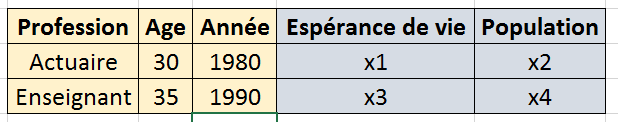

In [2]:
NbImage("cube1.png")

Dans cet exemple, il y a :
    
* 3 coordonnées : Age, Profession, Annéee
* 2 valeurs : Espérance de vie, Population

On peut représenter les donnés également comme ceci :

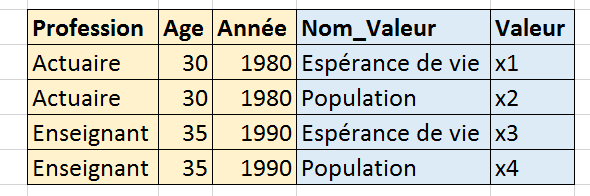

In [3]:
NbImage("cube2.png")

C'est assez simple. Prenons un exemple : [table de mortalité de 1960 à 2010](http://www.data-publica.com/opendata/7098--population-et-conditions-sociales-table-de-mortalite-de-1960-a-2010) qu'on récupère à l'aide de la fonction [table_mortalite_euro_stat](http://www.xavierdupre.fr/app/actuariat_python/helpsphinx/actuariat_python/data/population.html#actuariat_python.data.population.table_mortalite_euro_stat). C'est assez long (4-5 minutes) sur l'ensemble des données car elles doivent être prétraitées (voir la documentation de la fonction). Pour écouter, il faut utiliser le paramètre *stop_at*.

In [4]:
from actuariat_python.data import table_mortalite_euro_stat 
table_mortalite_euro_stat()

'mortalite.txt'

In [5]:
import os
os.stat("mortalite.txt")

os.stat_result(st_mode=33206, st_ino=73183493945221205, st_dev=2797837379, st_nlink=1, st_uid=0, st_gid=0, st_size=104871002, st_atime=1445699900, st_mtime=1445699915, st_ctime=1445699900)

In [6]:
import pandas
df = pandas.read_csv("mortalite.txt", sep="\t", encoding="utf8", low_memory=False)
df.head()

,annee,valeur,age,age_num,indicateur,genre,pays
0,2009,0.00080,Y01,1,DEATHRATE,F,AM
1,2008,0.00067,Y01,1,DEATHRATE,F,AM
2,2007,0.00052,Y01,1,DEATHRATE,F,AM
3,2006,0.00123,Y01,1,DEATHRATE,F,AM
4,2013,0.00016,Y01,1,DEATHRATE,F,AT


### Cubes de données avec xarray

#### création

Cette réprésentation sous forme de table n'est pas toujours très lisible. Les informations sont souvent répétées et les données sont vraiment multidimensionnelles. Le module [xarray](http://xarray.pydata.org/en/stable/) propose de distinguer les coordonnées des valeurs pour proposer des manipulations plus intuitives. Le module propose un DataFrame multidimensionnelle [DataSet](http://xarray.pydata.org/en/stable/data-structures.html#dataset).

In [7]:
from actuariat_python.data import table_mortalite_euro_stat 
table_mortalite_euro_stat()
import pandas
df = pandas.read_csv("mortalite.txt", sep="\t", encoding="utf8", low_memory=False)
df.columns

Index(['annee', 'valeur', 'age', 'age_num', 'indicateur', 'genre', 'pays'], dtype='object')

Dans ce cas-ci, pour reprendre la temrinologie du module [xarray](http://xarray.pydata.org/en/stable/), nous avons :

* les **dimensions** : annee, age_num, pays, genre
* les **valeurs** : une valeur par indicateur

On peut passer d'un [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) à un [DataSet](http://xarray.pydata.org/en/stable/data-structures.html#dataset) de la façon suivante :

* les colonnes indéxées représentent les dimensions
* les colonnes non indéxées sont les valeurs

On garde supprime les colonnes qui ne nous intéressent pas et les valeurs manquantes :

In [8]:
df2 = df[["annee", "age_num","indicateur","pays","genre","valeur"]].dropna().reset_index(drop=True)
df.columns, df2.columns

(Index(['annee', 'valeur', 'age', 'age_num', 'indicateur', 'genre', 'pays'], dtype='object'),
 Index(['annee', 'age_num', 'indicateur', 'pays', 'genre', 'valeur'], dtype='object'))

In [9]:
df2.head()

,annee,age_num,indicateur,pays,genre,valeur
0,2009,1,DEATHRATE,AM,F,0.00080
1,2008,1,DEATHRATE,AM,F,0.00067
2,2007,1,DEATHRATE,AM,F,0.00052
3,2006,1,DEATHRATE,AM,F,0.00123
4,2013,1,DEATHRATE,AT,F,0.00016


In [10]:
df2["indicateur"] = df2["indicateur"].astype(str)
df2["genre"] = df2["genre"].astype(str)
df2["pays"] = df2["pays"].astype(str)

In [11]:
df2.dtypes

annee           int64
age_num       float64
indicateur     object
pays           object
genre          object
valeur        float64
dtype: object

L'opération complexe consiste à faire passer les valeurs de la colonne *indicateur* en tant que colonnes. C'est l'objet de la méthode [pivot_table](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot_table.html?highlight=pivot#pandas.DataFrame.pivot_table) :

In [12]:
piv = df2.pivot_table(index=["annee", "age_num","pays","genre"],
                columns=["indicateur"],
               values="valeur")
piv.head()

indicateur                DEATHRATE  LIFEXP  PROBDEATH  PROBSURV  PYLIVED  \
annee age_num pays genre                                                    
1960  1       BE   F        0.00159    73.7    0.00159   0.99841    97316   
                   M        0.00207    68.2    0.00207   0.99793    96420   
                   T        0.00184    70.9    0.00184   0.99816    96856   
              BG   F        0.00652    73.2    0.00650   0.99350    95502   
                   M        0.00644    70.0    0.00642   0.99358    94801   

indicateur                SURVIVORS  TOTPYLIVED  
annee age_num pays genre                         
1960  1       BE   F          97393     7179465  
                   M          96520     6580601  
                   T          96945     6874529  
              BG   F          95813     7017023  
                   M          95107     6653130

In [13]:
piv.dtypes

indicateur
DEATHRATE     float64
LIFEXP        float64
PROBDEATH     float64
PROBSURV      float64
PYLIVED       float64
SURVIVORS     float64
TOTPYLIVED    float64
dtype: object

Les données sont maintenant prêtes à passer sous *xarray* :

In [14]:
import xarray
ds = xarray.Dataset.from_dataframe(piv)
ds

<xarray.Dataset>
Dimensions:     (age_num: 84, annee: 54, genre: 3, pays: 54)
Coordinates:
  * annee       (annee) int64 1960 1961 1962 1963 1964 1965 1966 1967 1968 ...
  * age_num     (age_num) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * pays        (pays) object 'AM' 'AT' 'AZ' 'BE' 'BG' 'BY' 'CH' 'CY' 'CZ' ...
  * genre       (genre) object 'F' 'M' 'T'
Data variables:
    DEATHRATE   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    LIFEXP      (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBDEATH   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBSURV    (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PYLIVED     (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    SURVIVORS   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    TOTPYLIVED  (annee, age_num, pays, genre) float64 nan nan nan nan nan ...

#### sélection

Il est facile ensuite d'extraire les données d'un pays avec la méthode [sel](http://xarray.pydata.org/en/stable/indexing.html#indexing-and-selecting-data) :

In [15]:
ds.sel(pays=["FR"])

<xarray.Dataset>
Dimensions:     (age_num: 84, annee: 54, genre: 3, pays: 1)
Coordinates:
  * annee       (annee) int64 1960 1961 1962 1963 1964 1965 1966 1967 1968 ...
  * age_num     (age_num) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * pays        (pays) object 'FR'
  * genre       (genre) object 'F' 'M' 'T'
Data variables:
    DEATHRATE   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    LIFEXP      (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBDEATH   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBSURV    (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PYLIVED     (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    SURVIVORS   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    TOTPYLIVED  (annee, age_num, pays, genre) float64 nan nan nan nan nan ...

Ou de plusieurs pays :

In [16]:
ds.sel(pays=["FR", "BE"])

<xarray.Dataset>
Dimensions:     (age_num: 84, annee: 54, genre: 3, pays: 2)
Coordinates:
  * annee       (annee) int64 1960 1961 1962 1963 1964 1965 1966 1967 1968 ...
  * age_num     (age_num) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * pays        (pays) object 'FR' 'BE'
  * genre       (genre) object 'F' 'M' 'T'
Data variables:
    DEATHRATE   (annee, age_num, pays, genre) float64 nan nan nan 0.00159 ...
    LIFEXP      (annee, age_num, pays, genre) float64 nan nan nan 73.7 68.2 ...
    PROBDEATH   (annee, age_num, pays, genre) float64 nan nan nan 0.00159 ...
    PROBSURV    (annee, age_num, pays, genre) float64 nan nan nan 0.9984 ...
    PYLIVED     (annee, age_num, pays, genre) float64 nan nan nan 9.732e+04 ...
    SURVIVORS   (annee, age_num, pays, genre) float64 nan nan nan 9.739e+04 ...
    TOTPYLIVED  (annee, age_num, pays, genre) float64 nan nan nan 7.179e+06 ...

Ou plusieurs dimensions :

In [17]:
ds.sel(pays="FR", annee=2000)

<xarray.Dataset>
Dimensions:     (age_num: 84, genre: 3)
Coordinates:
    annee       int64 2000
  * age_num     (age_num) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
    pays        object 'FR'
  * genre       (genre) object 'F' 'M' 'T'
Data variables:
    DEATHRATE   (age_num, genre) float64 0.00043 0.00046 0.00044 0.00021 ...
    LIFEXP      (age_num, genre) float64 82.3 74.7 78.5 81.3 73.7 77.6 80.3 ...
    PROBDEATH   (age_num, genre) float64 0.00043 0.00046 0.00044 0.00021 ...
    PROBSURV    (age_num, genre) float64 0.9996 0.9995 0.9996 0.9998 0.9997 ...
    PYLIVED     (age_num, genre) float64 9.957e+04 9.944e+04 9.951e+04 ...
    SURVIVORS   (age_num, genre) float64 9.959e+04 9.947e+04 9.953e+04 ...
    TOTPYLIVED  (age_num, genre) float64 8.196e+06 7.432e+06 7.817e+06 ...

Pour accéder à la série ``LIFEXP`` pour les hommes, les années 2000 et 2010, le pays ``FR``, on fait la différence, puis on la récupère sous forme de DataFrame :

In [18]:
(ds.sel(pays="FR", annee=2010, genre="T")["LIFEXP"] - 
 ds.sel(pays="FR", annee=2000, genre="T")["LIFEXP"]).to_dataframe().head()

,LIFEXP,genre,pays
age_num,,,
1,2.6,T,FR
2,2.6,T,FR
3,2.6,T,FR
4,2.6,T,FR
5,2.6,T,FR


On a gagné presque deux ans et demi d'espérance de vie à la naissance en 10 ans.

In [19]:
(ds.sel(pays="FR", annee=2010, genre=["F","M"])["LIFEXP"] - 
 ds.sel(pays="UK", annee=2010, genre=["F","M"])["LIFEXP"]).to_dataframe().head()

LIFEXP  annee
age_num genre               
1       F         2.6   2010
        M        -0.3   2010
2       F         2.7   2010
        M        -0.4   2010
3       F         2.7   2010

#### Quelques graphes

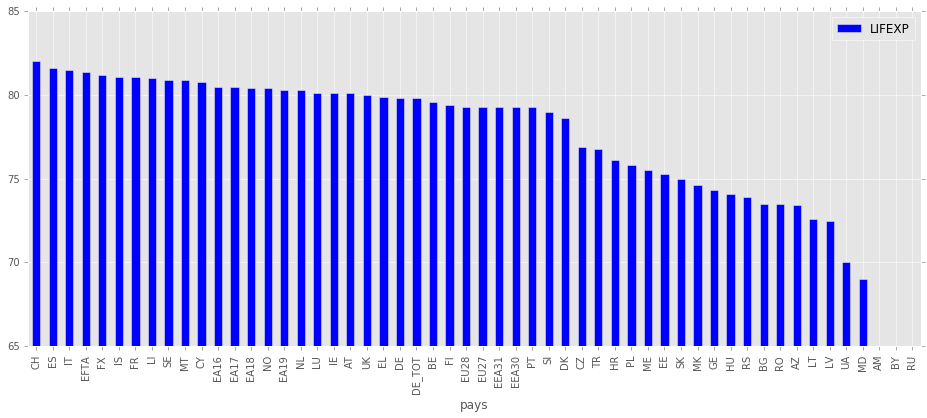

In [20]:
ds.sel(annee=2010,age_num=1,genre="T")["LIFEXP"].to_dataframe() \
            .sort_values("LIFEXP", ascending=False) \
            .plot(y="LIFEXP", kind="bar", figsize=(16,6), ylim=[65,85])

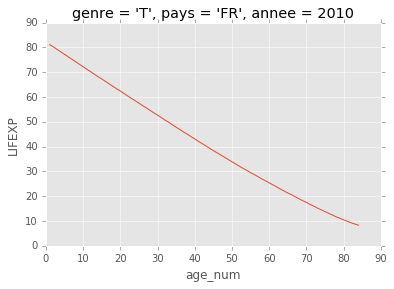

In [21]:
ds.sel(annee=2010,genre="T",pays="FR")["LIFEXP"].plot()

### Exercice 1 : que font les lignes suivantes ?

On pourra s'aider des pages :

* [align nad reindex](http://xarray.pydata.org/en/stable/indexing.html#align-and-reindex)
* [transforming datasets](http://xarray.pydata.org/en/stable/data-structures.html?highlight=assign#transforming-datasets)

In [22]:
ds.assign(LIFEEXP_add = ds.LIFEXP-1)

<xarray.Dataset>
Dimensions:      (age_num: 84, annee: 54, genre: 3, pays: 54)
Coordinates:
  * annee        (annee) int64 1960 1961 1962 1963 1964 1965 1966 1967 1968 ...
  * age_num      (age_num) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * pays         (pays) object 'AM' 'AT' 'AZ' 'BE' 'BG' 'BY' 'CH' 'CY' 'CZ' ...
  * genre        (genre) object 'F' 'M' 'T'
Data variables:
    DEATHRATE    (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    LIFEXP       (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBDEATH    (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBSURV     (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PYLIVED      (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    SURVIVORS    (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    TOTPYLIVED   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    LIFEEXP_add  (annee, age_num, pays, genre) float64 

In [23]:
meanp = ds.mean(dim="pays")
ds1, ds2 = xarray.align(ds, meanp, join='outer')

In [24]:
joined = ds1.assign(meanp = ds2["LIFEXP"])

In [25]:
joined.to_dataframe().head()

DEATHRATE  LIFEXP  PROBDEATH  PROBSURV  PYLIVED  \
age_num annee genre pays                                                    
1       1960  F     AM          NaN     NaN        NaN       NaN      NaN   
                    AT          NaN     NaN        NaN       NaN      NaN   
                    AZ          NaN     NaN        NaN       NaN      NaN   
                    BE      0.00159    73.7    0.00159   0.99841    97316   
                    BG      0.00652    73.2    0.00650   0.99350    95502   

                          SURVIVORS  TOTPYLIVED  meanp  
age_num annee genre pays                                
1       1960  F     AM          NaN         NaN  73.52  
                    AT          NaN         NaN  73.52  
                    AZ          NaN         NaN  73.52  
                    BE        97393     7179465  73.52  
                    BG        95813     7017023  73.52

### Lire, écrire des datasets

Le module [xarray](http://xarray.pydata.org/en/stable/) s'appuie sur le module [netCDF4](https://github.com/Unidata/netcdf4-python) qui lui-même est un [wrapper](https://fr.wikipedia.org/wiki/Adaptateur_(patron_de_conception)) poython de la libraire [netCDF-c](https://github.com/Unidata/netcdf-c). Celle-ci est spécialisée dans la lecture et l'écriture de données scientifiques. Concrètement, ce n'est pas [xarray](http://xarray.pydata.org/en/stable/) qui s'en occupe mais [netCDF4](https://github.com/Unidata/netcdf4-python). Cela explique la syntaxe décrite par [Serialization and IO](http://xarray.pydata.org/en/stable/io.html#serialization-and-io) :

In [26]:
ds.data_vars

Data variables:
    DEATHRATE   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    LIFEXP      (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBDEATH   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PROBSURV    (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    PYLIVED     (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    SURVIVORS   (annee, age_num, pays, genre) float64 nan nan nan nan nan ...
    TOTPYLIVED  (annee, age_num, pays, genre) float64 nan nan nan nan nan ...

In [27]:
try:
    ds.to_netcdf('mortalite.nc')
except ValueError as e:
    # it breaks with pandas 0.17
    # xarray has to be updated
    print("l'écriture a échoué")
    pass

l'écriture a échoué


C'est un format binaire plus efficace que le format texte :

In [28]:
import os
if os.path.exists("mortalite.nc"):
    os.stat('mortalite.nc').st_size, os.stat('mortalite.txt').st_size

On relit :

In [29]:
if os.path.exists("mortalite.nc"):
    ds_lu = xarray.open_dataset('mortalite.nc')
    ds_lu

Le module [xarray](http://xarray.pydata.org/en/stable/) propose également de lire des données de plusieurs fichiers pour ne former qu'un seul dataset (voir [Combining multiple files](http://xarray.pydata.org/en/stable/io.html#combining-multiple-files)) :

In [30]:
pays = list(_.values for _ in ds["pays"])
pays[:5]

['AM', 'AT', 'AZ', 'BE', 'BG']

In [31]:
for p in pays[:5]:
    print("enregistre", p)
    d = ds.sel(pays=[p])
    try:
        d.to_netcdf("mortalite_pays_%s.nc" % p)
    except ValueError:
        print("l'écriture a échoué pour", p)

enregistre AM
l'écriture a échoué pour AM
enregistre AT
l'écriture a échoué pour AT
enregistre AZ
l'écriture a échoué pour AZ
enregistre BE
l'écriture a échoué pour BE
enregistre BG
l'écriture a échoué pour BG


On relit :

In [32]:
import os
if os.path.exists("mortalite_pays_AM.nc"):
    ds_lu2 = xarray.open_mfdataset('mortalite_pays*.nc')
    ds_lu2

A quoi ça sert ?

Lorsqu'on travaille avec des gros fichiers de données, on cherche à retarder le plus possible l'exécution d'un calcul, on manipule les données sans les charger en mémoire. On appelle ceci [évaluation paresseuse](https://fr.wikipedia.org/wiki/%C3%89valuation_paresseuse) ou [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation) en anglais. [xarray](http://xarray.pydata.org/en/stable/) et [dask](http://dask.pydata.org/en/latest/) permettent de faire cela (voir [Using dask with xarray](http://xarray.pydata.org/en/stable/dask.html#dask-io)). La logique qu'on suit est alors assez proche de la [programmation fonctionnelle](https://fr.wikipedia.org/wiki/Programmation_fonctionnelle).